# A First look at the Data

## Introduction

In this section some basic analysis will be done in order to explain the structure of the data and perform a few sanity checks. Examples of simple plots of the raw data will be provided.

Import the required modules:

In [1]:
import mne
import os
import numpy as np
import os.path as op
import warnings
import inspect
from mne_bids import (
    BIDSPath,
    make_dataset_description,
    print_dir_tree,
    read_raw_bids,
)

warnings.filterwarnings('ignore')

### File Overview

The chapter relies on the input file (embedded in the BIDS structure)

```
<BIDS_ROOT>/sub-01/ses-01/meg/sub-01_ses-01_task-SpAtt_run-01_meg.fif
```

## Loading the BIDS Data

The first step is to prepare the data for reading. The OPM data, which has been organized according to the BIDS format, will be used in this section. This involves setting the `data_path` which defines the MNE BIDS folder.

Specify the BIDS parameters. The <code><a>data_path</a></code> is dependent on where you downloaded and stored the data. 

In [4]:
subject = '01'  
session = '01'  
task = 'SpAtt'
run = '01'  
meg_suffix = 'meg'
meg_extension = '.fif'
events_suffix = 'events'
events_extension = '.tsv'

# data_path='C:/Users/rakshita/Documents/Cerca_raw_files'
data_path = '/Users/o.jensen@bham.ac.uk/Library/CloudStorage/Dropbox/FLUX/OPM-Oxf/fif'

bids_root = op.join(data_path, "Cerca_Spatt_BIDS")
bids_path = BIDSPath(subject=subject, session=session,
                     task=task, run=run, suffix=meg_suffix, 
                     extension=meg_extension, root=bids_root)

After the path have been defined the data can be read:

In [5]:
print(bids_path)
raw = read_raw_bids(bids_path=bids_path, 
                    verbose=False,
                    extra_params={'preload':True})

/Users/o.jensen@bham.ac.uk/Library/CloudStorage/Dropbox/FLUX/OPM-Oxf/fif/Cerca_Spatt_BIDS/sub-01/ses-01/sub-01_ses-01_task-SpAtt_run-01_meg.fif


## Inspecting at the Data

To obtain some basic information from the `.fif` file write:

In [6]:
print(raw)

<Raw | sub-01_ses-01_task-SpAtt_run-01_meg.fif, 219 x 1539808 (2053.1 s), ~2.52 GiB, data loaded>


The dataset has a size of 2.52 GB and spans a total recording duration of 2053.1 seconds. After downsampling to 750 Hz, this yields 1,539,808 sample points across the entire recording. The data were collected from 219 channels, comprising 192 magnetometer sensors and 27 stimulus-related channels.

To get some additional information:

In [7]:
print(raw.info)

<Info | 16 non-empty values
 bads: []
 ch_names: Trigger 1, Trigger 2, Trigger 3, Trigger 4, Trigger 5, Trigger ...
 chs: 27 Stimulus, 192 Magnetometers
 custom_ref_applied: False
 description: Anonymized using a time shift to preserve age at acquisition
 dev_head_t: MEG device -> head transform
 device_info: 2 items (dict)
 dig: 15603 items (3 Cardinal, 15600 Extra)
 experimenter: mne_anonymize
 file_id: 4 items (dict)
 highpass: 0.1 Hz
 line_freq: 50.0
 lowpass: 250.0 Hz
 meas_date: unspecified
 meas_id: 4 items (dict)
 nchan: 219
 projs: []
 sfreq: 750.0 Hz
 subject_info: <subject_info | his_id: sub-01, sex: 0, hand: 0>
>


This information shows the important parameters of the dataset. For instance, the sampling frequency is 750 Hz (sfreq). The data was lowpass filtered at 250.0 Hz (lowpass) prior to downsampling. The experimenter is anonymised and the recording time and date removed to comply with GDPR rules.

**Question 1:** What role does the 250 Hz analogue low‑pass filter play in the data acquisition process? (See Chapter 3 in [1])

### Understanding the triaxial sensor layout

As a first step inspect the sensors information by plotting the labels of the first 40 sensors:

In [8]:
ch_names = raw.info['ch_names']
print(ch_names[1:40])

['Trigger 2', 'Trigger 3', 'Trigger 4', 'Trigger 5', 'Trigger 6', 'Trigger 7', 'Trigger 8', 'Trigger 9', 'Trigger 10', 'Trigger 11', 'BNC 1 Z', 'BNC 2 Z', 'BNC 3 Z', 'BNC 4 Z', 'BNC 5 Z', 'BNC 6 Z', 'BNC 7 Z', 'BNC 8 Z', 'BNC 9 Z', 'BNC 10 Z', 'BNC 11 Z', 'BNC 12 Z', 'BNC 13 Z', 'BNC 14 Z', 'BNC 15 Z', 'BNC 16 Z', 'F1 A1 Z', 'F1 A1 Y', 'F1 A1 X', 'F3 A3 Z', 'F3 A3 Y', 'F3 A3 X', 'F5 A6 Z', 'F5 A6 Y', 'F5 A6 X', 'F7 C3 Z', 'F7 C3 Y', 'F7 C3 X', 'F9 A4 Z']


The first 10 channels are trigger lines. Then follows 16 BNC channels which can be used to acquire digitized analogue input. The subsequent OPM sensors are organized according to triplets for each sensor. Each sensor measures the field in 3 directions denoted by X, Y and Z. The Z direction corresponds to conventional magnetometers in SQUID-based MEG system measuring the field perpendicular to the scalp surface.  

To show the layout of the sensors write:

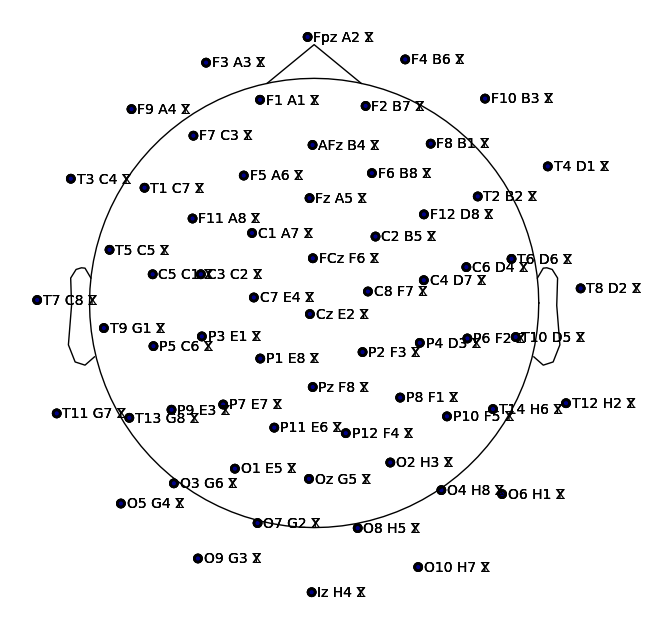

In [9]:
raw.plot_sensors(kind='topomap', show_names=True);

We will here isolate the labels for the X, Y and Z directions:

In [10]:
OPMX = [item for item in raw.ch_names if item.endswith("X")]
OPMY = [item for item in raw.ch_names if item.endswith("Y")]
OPMZ = [item for item in raw.ch_names if item.endswith("Z") and not item.startswith("BNC")]

**Question 2** Why is the  field from the Z-axis sensor typically more easy to interpret than for the X- and Y-axes?

In order to calculate on plot the power a few flat sensors must be set as bad:

In [11]:
ch_names = raw.info['ch_names']
bad_chs = ['B4', 'H6']
bad_channels = [name for name in ch_names if any(ch in name for ch in bad_chs)]
raw.info['bads'] = bad_channels
raw.save
# Print the bad channels 
print("Bad channels marked:", raw.info['bads'])

Bad channels marked: ['T14 H6 Z', 'T14 H6 Y', 'T14 H6 X', 'AFz B4 Z', 'AFz B4 Y', 'AFz B4 X']


### Estimating the power spectra
The data object (raw) allows for a simple inspection of the data by calculating the spectra: As a first step calculate the PSDs of all the OPM sensors for 0-120 HZ frequency range using the MNE functions. Also note that the sampling frequency 750 Hz and therefore chose $N_{FFT}$ = 1500 to achieve a 0.5 Hz spectral resolution. A Welch method is use with 50% overlapping time-windows. Per default a Hamming taper is applied to each time-window prior to calculation the Fourier transformation.

In [15]:
n_fft = 1500
raw_PSDZ = raw.compute_psd(method="welch", fmin=0.0, fmax=120, picks=OPMZ, n_fft=n_fft, n_overlap=int(n_fft/2))

Effective window size : 2.000 (s)


To plot the PSDs for the OPMs for the Z direction:

Plotting power spectral density (dB=True).


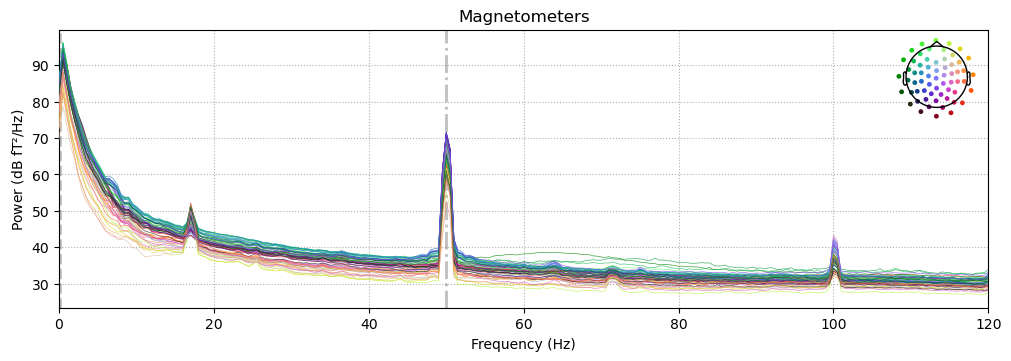

In [16]:
%matplotlib inline  
raw_PSDZ.plot(exclude='bads',picks='mag');

Note the 50 Hz line noise. The frequency of the line noise is 50 Hz in European countries including Russia as well as Asian countries including India and China. It is 60 in South Korea as well as South and North America. In Japan it will be either 50 or 60 Hz depending on the region.

## Inspecting the raw data using the interactive data browser

It is also possible to browse the data using an interactive plot. This will here be illustrated for the OPM Z sensors sensitive to the radial fields:

In [18]:
%matplotlib qt
raw.plot(duration=10, title='Raw', picks=OPMZ);

Using pyopengl with version 3.1.6


This will open the plot in a new window. Use the arrow keys to move over channels and time. Click on the help button for more information.

**Question 3:** Scroll through the OPM data and identify the following artefacts (include screen dumps in the response):

- The left and right cue onsets
- Eye‑blink  
- A muscle contraction (characterised by high‑frequency activity)  
- The cardiac artefact  

## References

[1] Smith, W.S. (1997) *The Scientist and Engineer's Guide to Digital Signal Processing*. California Technical Publishing. ISBN 0-9660176-3-3. Online version: [The Scientist and Engineer's Guide to DSP](https://www.dspguide.com/)
